In [1]:
## Load all libraries
import numpy as np
import torch
import os
import math
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from huggingface_hub import interpreter_login, logout
from datasets import load_dataset
from transformers import ViTConfig, ViTImageProcessor, ViTForImageClassification
from transformers import image_utils as hf_image_utils
from PIL import Image, ImageOps
import scipy
import pywt
import pywt.data
from torch_cka import CKA
from torchinfo import summary
import pickle
from scipy.fftpack import dct, idct
plt.gray()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

<Figure size 640x480 with 0 Axes>

In [2]:
##Get random samples of imagenet data based on class given
import os
import random
from PIL import Image

def class_sampler(class_id, n_samples=1):
    class_dir = f'./dataset_classes/{class_id}/'
    files = os.listdir(class_dir)
    img_files = random.sample([i for i in range(50)], min(n_samples, len(files)))
    img_paths = [f'{class_dir}{class_id}_{img_file}.jpg' for img_file in img_files]
    return [Image.open(img_path) for img_path in img_paths]


In [3]:
def class_sampler_2(class_id, n_samples=1):
    class_dir = f'./dataset_classes/{class_id}/'
    files = os.listdir(class_dir)
    indexes = min(n_samples, len(files))
    img_files = [i for i in range(50)][0:indexes]
    img_paths = [f'{class_dir}{class_id}_{img_file}.jpg' for img_file in img_files]
    return [Image.open(img_path) for img_path in img_paths]


In [4]:
## Load ViT models and processor
model_paths = {
    'base': 'google/vit-base-patch16-224',
    'dino': 'facebook/dino-vitb16',
    'mae': 'facebook/vit-mae-base',
    'large': 'google/vit-large-patch16-224',
    'huge': 'google/vit-huge-patch16-224'
}
from transformers import ViTForImageClassification
vit_base = ViTForImageClassification.from_pretrained(model_paths['base']).to('cuda')
vit_dino = ViTForImageClassification.from_pretrained(model_paths['dino']).to('cuda')
vit_mae = ViTForImageClassification.from_pretrained(model_paths['mae']).to('cuda')
vit_large = ViTForImageClassification.from_pretrained(model_paths['large']).to('cuda')
# vit_base = ViTForImageClassification.from_pretrained(model_paths['base'])
# vit_dino = ViTForImageClassification.from_pretrained(model_paths['dino'])
# vit_mae = ViTForImageClassification.from_pretrained(model_paths['mae'])
# vit_large = ViTForImageClassification.from_pretrained(model_paths['large'])
# vit_huge = ViTForImageClassification.from_pretrained(model_paths['huge'])

base_processor = ViTImageProcessor.from_pretrained(model_paths['base'])
large_processor = ViTImageProcessor.from_pretrained(model_paths['large'])
# huge_processor = ViTImageProcessor.from_pretrained(model_paths['huge'])
dino_processor = ViTImageProcessor.from_pretrained(model_paths['dino'])
mae_processor = ViTImageProcessor.from_pretrained(model_paths['base'])


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/vit-mae-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def wt_decomposition(img,level):
    """
    Stores the basis images corresponding to the Discrete Wavelet Transform of img

    Args
      img: a PIL Image, either RGB or Grayscale (or) a 3-channel numpy array
      level: The level of decomposition

    Returns:
    A 1D list, containing all components
    """
    # if isinstance(img, Image.Image):
    #     np_img = np.array(img.convert('L'))
    # else:
    #     weights = np.array([0.299, 0.587, 0.114])
    #     np_img = (weights[0]*img[0] + weights[1]*img[1] + weights[2]*img[2]).astype('uint8')
    # if level == 1:
    #     scaled_bases = pywt.dwt2(np_img, 'haar')
    #     basis_imgs = []
    
    #     for i in scaled_bases:
        
    #         if isinstance(i, np.ndarray):
    #             zero_coeff = np.zeros_like(i)
    #             basis_img = pywt.idwt2(coeffs = (i, (None, None, None)), wavelet='haar')
    #             basis_imgs.append(basis_img)
    #         else:
    #             for j in i:
    #                 zero_coeff = np.zeros_like(j)
    #                 basis_img = pywt.idwt2(coeffs = (j, (None, None, None)), wavelet='haar')
    #                 basis_imgs.append(basis_img)
    #     return basis_imgs
    # else:
    scaled_bases = pywt.wavedec2(img,'haar',level=level)
    basis_imgs = []
    img_shapes = []
    for i in range(level):
        img_shapes.append(scaled_bases[i+1][0].shape)
    for i in range(len(scaled_bases)):
        if isinstance(scaled_bases[i],np.ndarray):
            coefs = [np.zeros_like(scaled_bases[0]),]  + [[np.zeros((img_shapes[k][0],img_shapes[k][1])),np.zeros((img_shapes[k][0],img_shapes[k][1])),np.zeros((img_shapes[k][0],img_shapes[k][1]))] for k in range(level)]
            coefs[0] = scaled_bases[i]
            basis_img = pywt.waverec2(coeffs=coefs,wavelet='haar')
            basis_imgs.append(basis_img)
        else:
            for j in range(len(scaled_bases[i])):
                # coefs = [np.zeros_like(scaled_bases[0]),] + [[np.zeros((scaled_bases[0].shape[0]*(2**k),scaled_bases[0].shape[1]*(2**k))),np.zeros((scaled_bases[0].shape[0]*(2**k),scaled_bases[0].shape[1]*(2**k))),np.zeros((scaled_bases[0].shape[0]*(2**k),scaled_bases[0].shape[1]*(2**k)))] for k in range(level)]
                coefs = [np.zeros_like(scaled_bases[0]),] + [[np.zeros((img_shapes[k][0],img_shapes[k][1])),np.zeros((img_shapes[k][0],img_shapes[k][1])),np.zeros((img_shapes[k][0],img_shapes[k][1]))] for k in range(level)]
                coefs[i][j] = scaled_bases[i][j]
                basis_img = pywt.waverec2(coeffs=coefs,wavelet='haar')
                basis_imgs.append(basis_img)
    return basis_imgs

In [6]:
def wav_decomposition_patched(img,level, patch_dim=16):
    """Docstring goes here"""
    np_img = np.array(img)
    # weights = np.array([0.229, 0.587, 0.114])
    # np_img = (weights[0]*img[0] + weights[1]*img[1] + weights[2]*img[2])
    patches = np.zeros(shape=(np_img.shape[0], np_img.shape[1],np_img.shape[2], (1 + 3*level)))
    for k in range(np_img.shape[0]):
        for i in range(0, np_img.shape[1], patch_dim):
            for j in range(0, np_img.shape[2], patch_dim):
                patch_wt = wt_decomposition(np_img[k,i:i+patch_dim, j:j+patch_dim],level)
                
                patch = np.zeros(shape=(patch_dim, patch_dim, 1+3*level))
                for l in range(patches.shape[3]):
                    patch[:, :, l] = patch_wt[l]
    
                patches[k,i : i + patch_dim, j : j + patch_dim, :] = patch
    return patches

def wav_channel_decomposition_patched(img, level, patch_dim=16):
    """Docstring goes here"""

    np_img = np.array(img)
    patches = np.zeros(shape=(224, 224, 1+3*level))

    for i in range(0, np_img.shape[0], patch_dim):
        for j in range(0, np_img.shape[1], patch_dim):
            patch_wt = wt_decomposition(np_img[i:i+patch_dim, j:j+patch_dim],level)            
            patch = np.zeros(shape=(patch_dim, patch_dim, patch_dim**2))
            for l in range(patch_dim):
                for m in range(patch_dim):
                    single_patch_dct = np.zeros_like(patch_dct)
                    single_patch_dct[l, m] = patch_dct[l, m]
                    patch_idct = idct2(single_patch_dct)
                    patch[:, :, l*patch_dim + m] = patch_idct

            patches[i : i + patch_dim, j : j + patch_dim, :] = patch
    return patches, patch_weights

def wav_cls_decomposition(img, patch_dim=16):
    """Docstring goes here"""

    def dct2(img):
        return dct(dct(img, axis=-2, norm='ortho'), axis=-1, norm='ortho')
    def idct2(img):
        return idct(idct(img, axis=-2, norm='ortho'), axis=-1, norm='ortho')

    np_img = np.array(img)
    patches = np.zeros(shape=(224, 224, 256))
    
    patch_weights = np.zeros(shape=(196, 256))
    
    for i in range(0, np_img.shape[0], patch_dim):
        for j in range(0, np_img.shape[1], patch_dim):
            patch_dct = dct2(np_img[i:i+patch_dim, j:j+patch_dim])
            patch_weights[int(14 * (i/16) + j/16), :] = patch_dct.flatten()
            
            patch = np.zeros(shape=(patch_dim, patch_dim, patch_dim**2))
            for l in range(patch_dim):
                for m in range(patch_dim):
                    single_patch_dct = np.zeros_like(patch_dct)
                    single_patch_dct[l, m] = patch_dct[l, m]
                    patch_idct = idct2(single_patch_dct)
                    patch[:, :, l*patch_dim + m] = patch_idct

            patches[i : i + patch_dim, j : j + patch_dim, :] = patch
    return patches[:16, :16, :], patch_weights[0, :]

In [7]:
def composition_analysis_patched(img:Image.Image, transform='fft', processor=base_processor, model=vit_base,level=1,preprocessed=False,device='cuda',layer = -1):
    model.to(device)
    model.eval()
    if model == vit_base:
        hidden_size = 768
    elif model == vit_large:
        hidden_size = 1024
    with torch.no_grad():
        if not preprocessed:
            img_np = np.asarray(img)
            if img_np.ndim == 2:
                img = img.convert('RGB')
            preprocessed_img = processor(img, return_tensors='np')['pixel_values'][0]
            preprocessed_img_pt = processor(img, return_tensors='pt')['pixel_values'].to(device)
        else:
            preprocessed_img = img.squeeze(0).numpy()
            preprocessed_img_pt = img.to(device)
        img_reps = model(preprocessed_img_pt, output_hidden_states=True).hidden_states
        img_reps = torch.stack(img_reps, dim=0).squeeze()[layer]
        # composed_reps = torch.zeros_like(img_reps)
        n_decomps = 0
        if transform == 'fft':
            basis_imgs = fft_decomposition_patched(preprocessed_img)
            n_decomps = basis_imgs.shape[2]
            for i in range(n_decomps):
                basis = basis_imgs[:, :, i]
                basis = np.tile(basis, (3, 1, 1))
                basis = torch.from_numpy(basis).to(device)

                basis_reps = model(basis[None, :, :, :].float(), output_hidden_states=True).hidden_states
                basis_reps = torch.stack(basis_reps, dim=0).squeeze()
                composed_reps += basis_reps
        elif transform == 'dct':
            basis_imgs, basis_weights = dct_decomposition_patched(preprocessed_img)
            n_decomps = basis_imgs.shape[2]
            for i in range(n_decomps):
                basis = basis_imgs[:, :, i]
                basis = np.tile(basis, (3, 1, 1))
                basis = torch.from_numpy(basis).to(device)

                basis_reps = model(basis[None, :, :, :].float(), output_hidden_states=True).hidden_states
                basis_reps = torch.stack(basis_reps, dim=0).squeeze()
                composed_reps[:, 0, :] += basis_reps[:, 0, :]
                composed_reps += representation_weighting(basis_reps, basis_weights[:, i])
        else:
            basis_imgs = wav_decomposition_patched(preprocessed_img,level=level)
            n_decomps = basis_imgs.shape[3]
            components = torch.zeros((n_decomps,1,197,hidden_size))
            for i in range(n_decomps):
                basis = basis_imgs[:,:,:,i]
                # basis = np.tile(basis,(3,1,1))
                basis = torch.from_numpy(basis).to(device)
                basis_reps = model(basis[None, :, :, :].float(), output_hidden_states=True).hidden_states
                basis_reps = torch.stack(basis_reps, dim=0).squeeze()
                # composed_reps+=basis_reps
                components[i] = basis_reps[layer]
        
        return img_reps.cpu(), components.squeeze(1).cpu() # exclude cls token if computing compositionality scores

In [8]:
from sklearn.model_selection import train_test_split

In [47]:
indexes = np.random.randint(0,1000,40)
data = []
labels = []
wav_imgs = []
for i in indexes:
    imgs = class_sampler(i,50)
    for j in imgs:
        img_np = np.asarray(j)
        if img_np.ndim == 2:
            j = j.convert('RGB')
        preprocessed_img = base_processor(j, return_tensors='pt')['pixel_values'][0]
        preprocessed_img_pt = base_processor(j, return_tensors='pt')['pixel_values'].to('cuda')
        labels.append(torch.argmax(vit_base(preprocessed_img_pt)[0]))
        # wav_imgs.append(torch.from_numpy(wav_decomposition_patched(preprocessed_img,level=1)).float())
        # data.append(preprocessed_img)
    # labels.extend([i]*50)

In [9]:
def get_data(model=vit_base,preprocessor=base_processor,layer = 0,samples_per_cls=50,level=2,classes=1000):
    indexes = np.arange(0,1000)
    indexes = indexes[0:classes]
    data = []
    labels = []
    # wav_imgs = []
    for i in indexes:
        if i != 223:
            imgs = class_sampler(i,samples_per_cls)
            for j in imgs:
                # label = torch.zeros(1000)
                # label[i] = 1
                img_reps,com_reps = composition_analysis_patched(j,model=model,processor=preprocessor,transform='wav',level=level,layer=layer)
                with torch.no_grad():
                    if layer == -1:
                        img_reps = model.vit.layernorm(img_reps.to('cuda'))
                        for k in range(com_reps.shape[0]):
                            com_reps[k] = model.vit.layernorm(com_reps[k].to('cuda'))
                        img_reps_cls, com_reps_cls = img_reps[0,:], com_reps[:,0,:]
                        # img_cls = vit_base.classifier(img_reps_cls).float()
                        img_np = np.asarray(j)
                        if img_np.ndim == 2:
                            j = j.convert('RGB')
                        preprocessed_img_pt = preprocessor(j, return_tensors='pt')['pixel_values'].to('cuda')
                        labels.append(model(preprocessed_img_pt)[0])
                        # labels.append(label)
                        # print(com_reps_cls.shape)
                        data.append(com_reps_cls)
                    else:
                        img_np = np.asarray(j)
                        if img_np.ndim == 2:
                            j = j.convert('RGB')
                        img_reps = model.vit.layernorm(img_reps.to('cuda'))
                        for k in range(com_reps.shape[0]):
                            com_reps[k] = model.vit.layernorm(com_reps[k].to('cuda'))
                        img_reps_cls, com_reps_cls = img_reps[0,:], com_reps[:,0,:]
                        img_cls = model.classifier(img_reps_cls.to('cuda')).float()
                        labels.append(img_cls.unsqueeze(0))
                        data.append(com_reps_cls)
                        # preprocessed_img_pt = base_processor(j, return_tensors='pt')['pixel_values'].to('cuda')
                        
                        
    return data,labels

In [12]:
X_train,X_test,y_train,y_test = train_test_split(data3,labels,test_size = 0.3,random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_test,y_test,test_size = 0.5,random_state=42)

In [15]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(data1,labels,test_size = 0.3,random_state=42)
X_val1,X_test1,y_val1,y_test1 = train_test_split(X_test1,y_test1,test_size = 0.5,random_state=42)

In [16]:
from torch.utils.data import Dataset

class Data(Dataset):
    def __init__(self,data,labels,transform = True):
        self.imgs = data
        self.labels = labels
        self.transform=transform
    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        # if self.transform:
        return self.imgs[idx],self.labels[idx]



In [284]:
for i in range(len(X_test)):
    X_test[i] = X_test[i].cpu()

In [285]:
for i in range(len(X_test1)):
    X_test1[i] = X_test1[i].cpu()

In [283]:
for i in range(len(y_test)):
    y_test[i] = y_test[i].cpu()

AttributeError: 'numpy.int64' object has no attribute 'cpu'

In [229]:
for i in range(len(y_test1)):
    y_test1[i] = y_test1[i].cpu()

In [17]:
# y_train = torch.from_numpy(np.array(y_train))
# X_test = torch.from_numpy(np.array(X_test))
# y_test = torch.from_numpy(np.array(y_test))
X_test1 = torch.from_numpy(np.array(X_test1))
y_test1 = torch.from_numpy(np.array(y_test1))

In [18]:
# train_data = Data(X_train,y_train)
# test_data = Data(X_test,y_test)
test_data1 = Data(X_test1,y_test1)

In [19]:
from torch.utils.data import DataLoader

# train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
test_loader1 = DataLoader(test_data1, batch_size=1, shuffle=True)
# testing_loader = DataLoader(testing_data,batch_size=1,shuffle=True)

In [8]:
import torch.nn.functional as F
from torch.nn.parameter import Parameter
class Approximator(torch.nn.Module):
    def __init__(self,level,model=vit_base):
        super().__init__()
        self.weight = Parameter(torch.rand(level*3 + 1))
        # if constraint:
        #     data = self.weight.data
        #     data = data.clamp(min=0)
        #     self.weight.data = data
        
        # self.weight.requires_grad=True
        self.model = model.classifier
        self.softmax = torch.nn.Softmax(dim=1)

        if self.model == vit_base:
            self.hidden_size = 768
        elif self.model == vit_large:
            self.hidden_size = 1024
    def forward(self,input: torch.Tensor)-> torch.Tensor:
        if input.shape[-1] == self.hidden_size:
            input = input.permute(0,-1,1)
        out = F.linear(input,self.weight)
        return self.model(out)

### Load models 

- [ ] Prepare train test val datasets for level 1, level 2
- [ ] Run the experiments for final layer of encoder outputs or non convex combinations
- [ ] Run the same experiments for convex combination
- [ ] Run the experiments for every layer of encoder
- [ ] Do the same analysis for level 1 daub wavelets.
- [ ] Do the same analysis for level 1 for vit-L
- [ ] Baseline accuracy of vit on validation set Imagenet

- [ ] Compare the accuracies of the learned model weights and the averaging of the component representations
- [ ] Baseline accuracies of the test set using the original image. level-1 - 0.8025350233488993  level-2 - 0.7918612408272181
- [ ] How each component is contributing especially the negative weighted components (Can check this in the image domain)
- [ ] Reconstruct the image using the learned weights and check the accuracy
- [ ] Show the reconstructed image with the learned weights
- [ ] Get the learned weights for every layer of the encoder (Or specific layers depending on which layer is more important)

#### Level 1

In [14]:
model_level_2_db4_adam = Approximator(level=2)
model_level_2_db4_adam.load_state_dict(torch.load('./Composition_fn_data/level_2_db4_Adam.pt'))

<All keys matched successfully>

In [15]:
model_level_2_db4_adam.weight

Parameter containing:
tensor([ 2.5711, -0.4190, -0.8332, -0.6606,  0.6943,  1.1134, -1.5679],
       requires_grad=True)

In [20]:
model_level_2_db4_adam_non_neg = Approximator(level=2)
model_level_2_db4_adam_non_neg.load_state_dict(torch.load('./Composition_fn_data/level_2_db4_Adam_NonNeg.pt'))

<All keys matched successfully>

In [16]:
model_level_2_db4_adam_con = Approximator(level=2)
model_level_2_db4_adam_con.load_state_dict(torch.load('./Composition_fn_data/level_2_db4_Adam_con.pt'))

<All keys matched successfully>

In [21]:
model_level_2_db4_adam_non_neg.weight

Parameter containing:
tensor([2.9223, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       requires_grad=True)

In [18]:
model_level_2_db4_adam_con.weight

Parameter containing:
tensor([0.8292, 0.0200, 0.0213, 0.0220, 0.0430, 0.0458, 0.0187],
       requires_grad=True)

In [25]:
model_level_2_db4_sgd = Approximator(level=2)
model_level_2_db4_sgd.load_state_dict(torch.load('./Composition_fn_data/level_2_db4_SGD.pt'))

<All keys matched successfully>

In [27]:
model_level_2_db4_sgd_non_neg = Approximator(level=2)
model_level_2_db4_sgd_non_neg.load_state_dict(torch.load('./Composition_fn_data/level_2_db4_SGD_NonNeg.pt'))

<All keys matched successfully>

In [28]:
model_level_2_db4_sgd_con = Approximator(level=2)
model_level_2_db4_sgd_con.load_state_dict(torch.load('./Composition_fn_data/level_2_db4_SGD_con.pt'))

<All keys matched successfully>

In [58]:
#load the model
model_sgd = Approximator(level = 2,model=vit_large)
model_sgd.load_state_dict(torch.load('./Composition_fn_data/level_2_vit_large_SGD.pt'))

#load the model
model_sgd_NonNeg = Approximator(level = 2,model=vit_large)
model_sgd_NonNeg.load_state_dict(torch.load('./Composition_fn_data/level_2_vit_large_SGD_NonNeg.pt'))

#load the model
model_sgd_con = Approximator(level = 2,model=vit_large)
model_sgd_con.load_state_dict(torch.load('./Composition_fn_data/level_2_vit_large_SGD_convex.pt'))

# #load the model
# model_Adam = Approximator(level = 2)
# model_Adam.load_state_dict(torch.load('./Composition_fn_data/level_2_Adam.pt'))

# #load the model
# model_Adam_NonNeg = Approximator(level = 2)
# model_Adam_NonNeg.load_state_dict(torch.load('./Composition_fn_data/level_2_Adam_NonNeg.pt'))
# #load the model
# model_Adam_con = Approximator(level = 2)
# model_Adam_con.load_state_dict(torch.load('./Composition_fn_data/level_2_Adam_con.pt'))

<All keys matched successfully>

In [11]:
model_sgd.weight

Parameter containing:
tensor([ 1.5238, -0.0148, -0.2191,  0.2979,  0.0619, -0.0135,  0.3477],
       requires_grad=True)

In [12]:
model_sgd_NonNeg.weight

Parameter containing:
tensor([1.8213, 0.2957, 0.3244, 0.1712, 0.0000, 0.3393, 0.2345],
       requires_grad=True)

In [13]:
model_sgd_con.weight

Parameter containing:
tensor([0.4038, 0.1153, 0.1046, 0.0851, 0.0912, 0.0661, 0.1339],
       requires_grad=True)

In [43]:
model_Adam.weight

Parameter containing:
tensor([ 2.9857,  0.3004, -0.9271, -0.2763,  0.0489,  0.0307, -0.3145],
       requires_grad=True)

In [44]:
model_Adam_NonNeg.weight

Parameter containing:
tensor([3.1340, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       requires_grad=True)

In [45]:
model_Adam_con.weight

Parameter containing:
tensor([0.8159, 0.0392, 0.0175, 0.0293, 0.0418, 0.0341, 0.0222],
       requires_grad=True)

In [62]:
#load the model
model_sgd = Approximator(level = 1,model=vit_large)
model_sgd.load_state_dict(torch.load('./Composition_fn_data/level_1_vit_large_SGD.pt'))

#load the model
model_sgd_NonNeg = Approximator(level = 1,model=vit_large)
model_sgd_NonNeg.load_state_dict(torch.load('./Composition_fn_data/level_1_vit_large_SGD_NonNeg.pt'))

#load the model
model_sgd_con = Approximator(level = 1,model=vit_large)
model_sgd_con.load_state_dict(torch.load('./Composition_fn_data/level_1_vit_large_SGD_con.pt'))

#load the model
model_Adam = Approximator(level = 1,model=vit_large)
model_Adam.load_state_dict(torch.load('./Composition_fn_data/level_1_vit_large_Adam.pt'))

#load the model
model_Adam_NonNeg = Approximator(level = 1,model=vit_large)
model_Adam_NonNeg.load_state_dict(torch.load('./Composition_fn_data/level_1_vit_large_Adam_NonNeg.pt'))
#load the model
model_Adam_con = Approximator(level = 1,model=vit_large)
model_Adam_con.load_state_dict(torch.load('./Composition_fn_data/level_1_vit_large_Adam_con.pt'))

<All keys matched successfully>

In [63]:
model_Adam.weight

Parameter containing:
tensor([ 2.5441, -0.2052,  0.0809,  0.0251], requires_grad=True)

In [64]:
model_Adam_NonNeg.weight

Parameter containing:
tensor([2.2043e+00, 3.4677e-03, 1.7289e-03, 2.2043e-03], requires_grad=True)

In [65]:
model_Adam_con.weight

Parameter containing:
tensor([0.7790, 0.0862, 0.0644, 0.0703], requires_grad=True)

In [66]:
model_sgd.weight

Parameter containing:
tensor([ 1.5292, -0.0092,  0.5474,  0.5021], requires_grad=True)

In [67]:
model_sgd_NonNeg.weight

Parameter containing:
tensor([1.6066, 0.3804, 0.4012, 0.4193], requires_grad=True)

In [68]:
model_sgd_con.weight

Parameter containing:
tensor([0.5273, 0.1636, 0.1475, 0.1616], requires_grad=True)

### Model accuracy on test set

In [34]:
def test(model,test_loader):
    with torch.no_grad():
        acc = 0
        for i, vdata in enumerate(test_loader):
            inputs,labels = vdata
            com_cls = model(inputs.to('cpu'))
            compose_cls = torch.argmax(com_cls).item()
            if compose_cls == labels:
                acc+=1
        return acc/len(test_loader)

In [35]:
test(model_level_1_adam,test_loader1)

0.781854569713142

In [36]:
test(model_level_1_adam_non_neg,test_loader1)

0.7798532354903269

In [37]:
test(model_level_1_adam_con,test_loader1)

0.7791861240827218

In [38]:
test(model_level_1_sgd,test_loader1)

0.7791861240827218

In [40]:
test(model_level_1_sgd_non_neg,test_loader1)

0.781854569713142

In [41]:
test(model_level_1_sgd_con,test_loader1)

0.771847898599066

In [345]:
test(model_level_2_adam,test_loader)

0.5063375583722481

In [347]:
test(model_level_2,test_loader)

0.5016677785190127

In [106]:
test(model_level_2_sgd.to('cpu'),test_loader)

0.4943295530353569

In [96]:
test(model_level_2_sgd_non_neg.to('cpu'),test_loader)

0.4829886591060707

In [97]:
test(model_level_2_sgd_con.to('cpu'),test_loader)

0.46364242828552366

In [116]:
for i,param in enumerate(vit_base.parameters()):
    print(param)

Parameter containing:
tensor([[[ 9.8962e-03,  1.4689e-02, -2.6690e-01, -5.8776e-04,  4.0510e-01,
           5.3885e-02, -2.2178e-02,  2.3369e-02,  4.0966e-02, -2.1950e-01,
           3.1851e-04, -1.1463e-02, -1.3613e-02,  1.0975e-03, -1.2994e-02,
          -7.2687e-03,  7.6848e-04,  5.7467e-02,  3.0104e-02, -6.2324e-03,
          -4.9313e-02,  5.0945e-03, -2.9701e-03, -1.9993e-02,  1.9781e-03,
           5.4685e-02,  4.0473e-03, -3.8214e-03,  3.6615e-02, -2.2641e-02,
           4.3593e-04,  2.3658e-02, -1.8996e-02,  1.7957e-02,  1.8261e-02,
           4.6318e-03,  5.1867e-02,  2.9562e-04, -5.8164e-03, -1.2062e-02,
           3.7889e-03, -9.2025e-04,  1.9424e-02,  1.3673e-02,  4.5668e-02,
           4.3681e-01, -1.1325e-02,  2.7734e-04,  3.6051e-02, -1.1955e-03,
          -3.1415e-03, -3.4800e-02,  7.8660e-03,  9.3829e-04,  2.2359e-02,
          -1.2542e-02, -2.9033e-02, -6.6412e-03,  8.0147e-03, -6.5374e-02,
          -6.4394e-03,  6.8283e-03,  1.0331e-02,  3.1159e-03,  2.7809e-02,
   

### Compare learned compositions vs average compositions

In [117]:
def compare(model,vit=vit_base,preprocessor = base_processor, samples_per_cls=50,level=2,classes=1000):

    indexes = np.arange(0,1000)
    indexes = indexes[0:classes]
    learned_acc = 0
    avg_acc = 0
    org_acc = 0
    count = 0
    for i in indexes:
        if i != 223:
            imgs = class_sampler_2(i,samples_per_cls)
            for j in imgs:
                # label = torch.zeros(1000)
                # label[i] = 1
                img_reps,com_reps = composition_analysis_patched(j,model = vit,processor=preprocessor,transform='wav',level=level,device='cuda')
                with torch.no_grad():
                    img_reps = vit.vit.layernorm(img_reps.to('cuda'))
                    for k in range(com_reps.shape[0]):
                        com_reps[k] = vit.vit.layernorm(com_reps[k].to('cuda'))
                    img_reps_cls, com_reps_cls = img_reps[0,:], com_reps[:,0,:]
                    model.to('cpu')
                    learned_cls = torch.argmax(model(com_reps_cls.unsqueeze(0))).item()
                    img_cls = torch.argmax(vit.classifier(img_reps_cls)).item()
                    com_cls = torch.argmax(vit.classifier(torch.mean(com_reps.to('cuda'),dim=0))).item()
                    if img_cls == i:
                        org_acc+=1
                    if com_cls == i:
                        avg_acc += 1
                    if learned_cls == i:
                        learned_acc+=1
                    count+=1
    return org_acc/count,avg_acc/count,learned_acc/count

In [109]:
org_acc,avg_acc,learned_acc = compare(model_level_1_sgd,samples_per_cls=1,level=1,classes=10)
print('Org acc: {}, Avg acc: {} Learned acc: {}'.format(org_acc,avg_acc,learned_acc))

Org acc: 0.8, Avg acc: 0.1 Learned acc: 0.9


In [88]:
org_acc,avg_acc,learned_acc = compare(model_level_1_sgd_non_neg,samples_per_cls=1,level=1,classes=10)
print('Org acc: {}, Avg acc: {} Learned acc: {}'.format(org_acc,avg_acc,learned_acc))

Org acc: 0.9, Avg acc: 0.3 Learned acc: 0.9


In [89]:
org_acc,avg_acc,learned_acc = compare(model_level_1_sgd_con,samples_per_cls=1,level=1,classes=10)
print('Org acc: {}, Avg acc: {} Learned acc: {}'.format(org_acc,avg_acc,learned_acc))

Org acc: 0.8, Avg acc: 0.1 Learned acc: 0.8


In [330]:
org_acc,avg_acc,learned_acc = compare(model_level_1_adam,samples_per_cls=5,level=1,classes=10)
print('Org acc: {}, Avg acc: {} Learned acc: {}'.format(org_acc,avg_acc,learned_acc))

Org acc: 0.9, Avg acc: 0.02 Learned acc: 0.86


In [90]:
org_acc,avg_acc,learned_acc = compare(model_level_1_adam_non_neg,samples_per_cls=1,level=1,classes=10)
print('Org acc: {}, Avg acc: {} Learned acc: {}'.format(org_acc,avg_acc,learned_acc))

Org acc: 1.0, Avg acc: 0.0 Learned acc: 1.0


In [91]:
org_acc,avg_acc,learned_acc = compare(model_level_1_adam_con,samples_per_cls=1,level=1,classes=10)
print('Org acc: {}, Avg acc: {} Learned acc: {}'.format(org_acc,avg_acc,learned_acc))

Org acc: 0.8, Avg acc: 0.2 Learned acc: 0.8


In [118]:
org_acc,avg_acc,learned_acc = compare(model_level_2_sgd,samples_per_cls=1,level=2,classes=10)
print('Org acc: {}, Avg acc: {} Learned acc: {}'.format(org_acc,avg_acc,learned_acc))

Org acc: 0.9, Avg acc: 0.0 Learned acc: 0.6


In [120]:
org_acc,avg_acc,learned_acc = compare(model_level_2_sgd_non_neg,samples_per_cls=1,level=2,classes=10)
print('Org acc: {}, Avg acc: {} Learned acc: {}'.format(org_acc,avg_acc,learned_acc))

Org acc: 0.9, Avg acc: 0.0 Learned acc: 0.5


In [121]:
org_acc,avg_acc,learned_acc = compare(model_level_2_sgd_con,samples_per_cls=1,level=2,classes=10)
print('Org acc: {}, Avg acc: {} Learned acc: {}'.format(org_acc,avg_acc,learned_acc))

Org acc: 0.9, Avg acc: 0.0 Learned acc: 0.7


### Reconstructing Images using model weights

In [43]:
def reconstruct(model,level,class_id = 4):
    sample_img = class_sampler_2(class_id)[0]
    preprocessed_img = base_processor(sample_img, return_tensors='np')['pixel_values'][0]
    basis_imgs = wav_decomposition_patched(preprocessed_img,level=level)
    # fig,ax = plt.subplots(1,2,figsize=(10,5))
    # ax[0].imshow(preprocessed_img.transpose(1,2,0))
    # ax[0].set_title('Original Image')
    summed_img = np.sum(basis_imgs,axis=-1)
    # ax[1].imshow(summed_img.transpose(1,2,0))
    # # ax[1].set_title('Summed Image')
    reconstructed_img = torch.matmul(torch.from_numpy(basis_imgs).float(),model.weight.data.float())
    return reconstructed_img.permute(1,2,0)
    # plt.imshow(reconstructed_img.permute(1,2,0))
    # plt.title('Learned Image')
    # plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


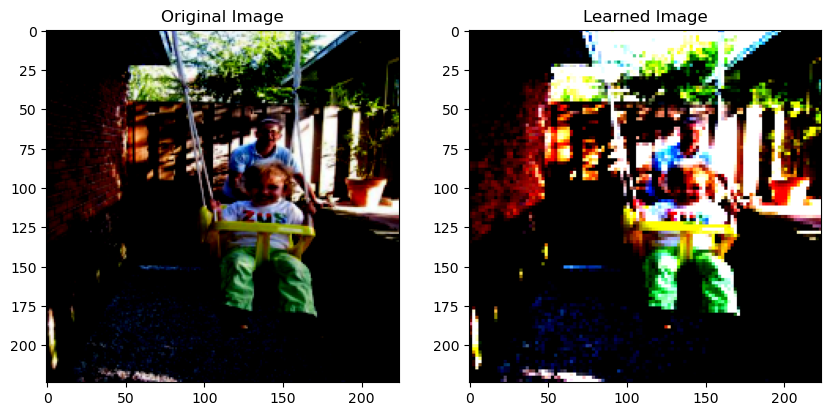

In [76]:
reconstruct(model_Adam,level=1,class_id=90)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


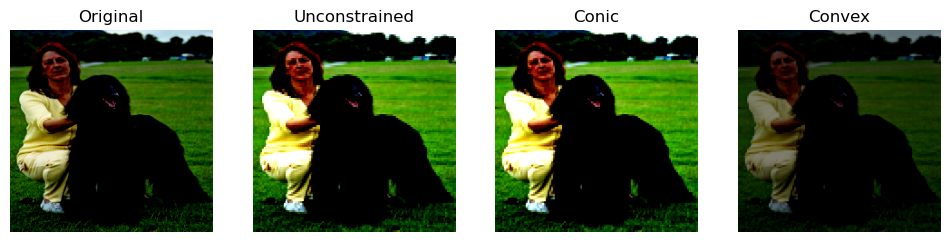

In [64]:
cls = 160
sample_img = class_sampler_2(cls)[0]
fig, ax = plt.subplots(1,4,figsize=(12,6))
ax[0].imshow(base_processor(sample_img, return_tensors='np')['pixel_values'][0].transpose(1,2,0))
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(reconstruct(model_sgd,level=1,class_id=cls))
ax[1].set_title('Unconstrained')
ax[1].axis('off')
ax[2].imshow(reconstruct(model_sgd_NonNeg,level=1,class_id=cls))
ax[2].set_title('Conic')
ax[2].axis('off')
ax[3].imshow(reconstruct(model_sgd_con,level=1,class_id=cls))
ax[3].set_title('Convex')
ax[3].axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


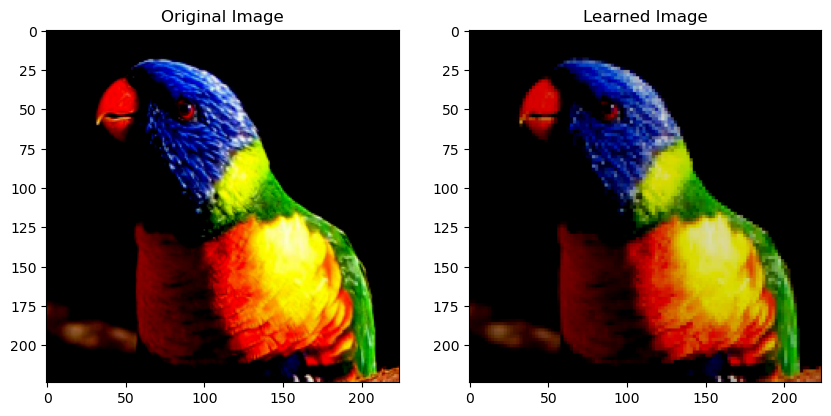

In [128]:
reconstruct(model_Adam_con,level=1,class_id=90)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


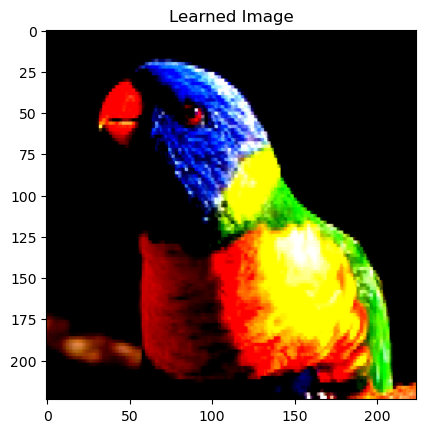

In [42]:
reconstruct(model_sgd,level=1,class_id=90)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


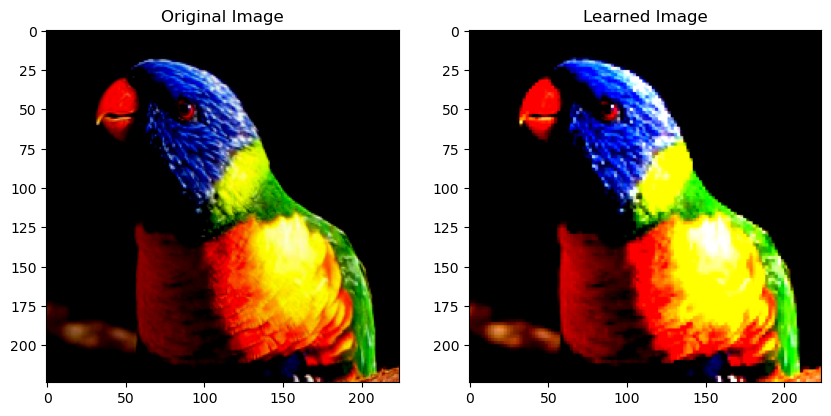

In [35]:
reconstruct(model_sgd_NonNeg,level=1,class_id=90)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


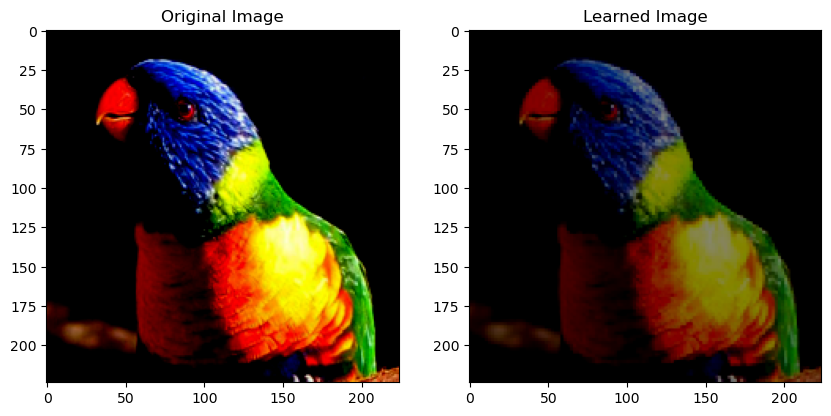

In [36]:
reconstruct(model_sgd_con,level=1,class_id=90)

### Accuracy of Learned Reconstructed Image

In [16]:
def reconstruct_acc(model,vit=vit_base,processor=base_processor,level=1,samples_per_cls=10,classes=50):
    indexes = np.arange(0,1000)
    indexes = indexes[0:classes]
    learned_acc = 0
    org_acc = 0
    count = 0
    for i in indexes:
        if i != 223:
            imgs = class_sampler_2(i,samples_per_cls)
            for j in imgs:
                img_np = np.asarray(j)
                if img_np.ndim == 2:
                    j = j.convert('RGB')
                preprocessed_img = processor(j, return_tensors='np')['pixel_values'][0]
                preprocessed_img_pt = processor(j, return_tensors='pt')['pixel_values']
                basis_imgs = wav_decomposition_patched(preprocessed_img,level=level)
                reconstructed_img = torch.matmul(torch.from_numpy(basis_imgs).float(),model.weight.data.float())
                org_cls = torch.argmax(vit(preprocessed_img_pt.to('cuda'))[0])
                learned_cls = torch.argmax(vit(reconstructed_img.unsqueeze(0).float().to('cuda'))[0])
                if org_cls == i:
                    org_acc += 1
                if learned_cls == i:
                    learned_acc+=1
                count+=1
    return org_acc/count,learned_acc/count

In [25]:
org_acc,learned_acc = reconstruct_acc(model_sgd,vit=vit_large,processor=large_processor,level=1,samples_per_cls=1,classes=200)
print('Org acc: {} Learned acc: {}'.format(org_acc,learned_acc))

Org acc: 0.835 Learned acc: 0.82


In [134]:
org_acc,learned_acc = reconstruct_acc(model_Adam,level=1,samples_per_cls=1,classes=200)
print('Org acc: {} Learned acc: {}'.format(org_acc,learned_acc))

Org acc: 0.84 Learned acc: 0.72


In [26]:
org_acc,learned_acc = reconstruct_acc(model_sgd_NonNeg,vit=vit_large,processor=large_processor,level=1,samples_per_cls=1,classes=200)
print('Org acc: {} Learned acc: {}'.format(org_acc,learned_acc))

Org acc: 0.835 Learned acc: 0.82


In [27]:
org_acc,learned_acc = reconstruct_acc(model_sgd_con,vit=vit_large,processor=large_processor,level=1,samples_per_cls=1,classes=200)
print('Org acc: {} Learned acc: {}'.format(org_acc,learned_acc))

Org acc: 0.835 Learned acc: 0.805


In [137]:
org_acc,learned_acc = reconstruct_acc(model_Adam_con,level=1,samples_per_cls=1,classes=200)
print('Org acc: {} Learned acc: {}'.format(org_acc,learned_acc))

Org acc: 0.84 Learned acc: 0.81


In [138]:
org_acc,learned_acc = reconstruct_acc(model_Adam_NonNeg,level=1,samples_per_cls=1,classes=200)
print('Org acc: {} Learned acc: {}'.format(org_acc,learned_acc))

Org acc: 0.84 Learned acc: 0.625
